# Movie Recommendation System

By: Anat Jacobson, Stephanie Ciaccia and Charlie Jin

---

## Overview

Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept. You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".

# Business Problem

Add business problem here

# Data Understanding

In [1]:
#importing packages

In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
import plotly.express as px
from matplotlib.ticker import StrMethodFormatter

from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

from collections import Counter
from nltk.corpus import stopwords

import pandas as pd
from IPython.display import display

Function for printing long lists

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# Source #1: Grouplens

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

### Import CSVs, Merge, and Clean all Data Needed
#### 4 Datasets imported:

- Movies:
- Links:
- Ratings:
- Tags:

In [58]:
#importing datasets
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv")
links_df = pd.read_csv("data/links.csv")
tags_df = pd.read_csv("data/tags.csv")

In [59]:
#checking the shape of all dfs
print('movies_df: ', movies_df.shape)
print('links_df: ',links_df.shape)
print('ratings_df: ',ratings_df.shape)
print('tags_df: ',tags_df.shape)

movies_df:  (9742, 3)
links_df:  (9742, 3)
ratings_df:  (100836, 4)
tags_df:  (3683, 4)


In [94]:
#attempting to make a loop of the above
# checking the shape of all dfs
# title = [movies_df, links_df, ratings_df, tags_df]
# for x in title:

#     print(f"'{x}: '", x.shape)

In [95]:
#displaying the first 5 rows of each data frames
display(movies_df.head())
display(links_df.head())
display(ratings_df.head())
display(tags_df.head())

,movieId,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title
0,1,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story
1,2,Adventure,Children,Fantasy,None,None,None,None,(1995),Jumanji
2,3,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men
3,4,Comedy,Drama,Romance,None,None,None,None,(1995),Waiting to Exhale
4,5,Comedy,None,None,None,None,None,None,(1995),Father of the Bride Part II


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Inspecting ratings


In [61]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [62]:
ratings.userId.value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

### Inspecting movies

In [64]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [65]:
#splitting genre into multiple columns
genre_split = pd.DataFrame(movies_df.genres.str.split('|',6).tolist(),
                                 columns = ['genre_1','genre_2', 'genre_3',
                                            'genre_4', 'genre_5', 'genre_6', 'genre_7'])

#merging dataframes
movies_df = pd.merge(pd.DataFrame(movies_df), pd.DataFrame(genre_split), left_index=True, right_index=True)

#dropping genre columns
movies_df.drop(columns="genres", inplace=True)

In [66]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genre_1  9742 non-null   object
 3   genre_2  6891 non-null   object
 4   genre_3  3673 non-null   object
 5   genre_4  1335 non-null   object
 6   genre_5  348 non-null    object
 7   genre_6  77 non-null     object
 8   genre_7  14 non-null     object
dtypes: int64(1), object(8)
memory usage: 685.1+ KB


In [67]:
#making year and title columns separate

#making year column
movies_df['year'] = movies_df['title'].str[-6:]

#making real_title column
movies_df['real_title'] = movies_df['title'].str[:-6]

#dropping original title column
movies_df = movies_df.drop(columns="title")

In [68]:
movies_df

,movieId,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title
0,1,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story
1,2,Adventure,Children,Fantasy,None,None,None,None,(1995),Jumanji
2,3,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men
3,4,Comedy,Drama,Romance,None,None,None,None,(1995),Waiting to Exhale
4,5,Comedy,None,None,None,None,None,None,(1995),Father of the Bride Part II
...,...,...,...,...,...,...,...,...,...,...
9737,193581,Action,Animation,Comedy,Fantasy,None,None,None,(2017),Black Butler: Book of the Atlantic
9738,193583,Animation,Comedy,Fantasy,None,None,None,None,(2017),No Game No Life: Zero
9739,193585,Drama,None,None,None,None,None,None,(2017),Flint
9740,193587,Action,Animation,None,None,None,None,None,(2018),Bungo Stray Dogs: Dead Apple


### Inspecting links

The additional ids will be helpful so we can pull additional movie information from TMBD's api for the content based model.

In [70]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Inspecting tags

In [72]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Merging files into one dataframe for cleaning

In [73]:
#merging
final_movies = pd.merge(ratings_df, movies_df, on="movieId", how="left")
final_movies = pd.merge(final_movies, links_df, on="movieId", how="left")
final_movies = pd.merge(final_movies, tags_df, on="movieId", how="left")

In [74]:
final_movies

,userId_x,movieId,rating,timestamp_x,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title,imdbId,tmdbId,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story,114709,862.0,336.0,pixar,1.139046e+09
1,1,1,4.0,964982703,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story,114709,862.0,474.0,pixar,1.137207e+09
2,1,1,4.0,964982703,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story,114709,862.0,567.0,fun,1.525286e+09
3,1,3,4.0,964981247,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men,113228,15602.0,289.0,moldy,1.143425e+09
4,1,3,4.0,964981247,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men,113228,15602.0,289.0,old,1.143425e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,(2017),Logan,3315342,263115.0,567.0,emotional,1.525284e+09
285758,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,(2017),Logan,3315342,263115.0,567.0,gritty,1.525284e+09
285759,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,(2017),Logan,3315342,263115.0,567.0,heartbreaking,1.525284e+09
285760,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,(2017),Logan,3315342,263115.0,567.0,predictible plot,1.525284e+09


## Data Preparation - Cleaning

To being, we will need to remove null values and split the genre column so this can be One Hot Encoded.

In [75]:
#saving as new dataframe for cleaning
movie_df = final_movies

In [76]:
#checking for null values
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId_x     285762 non-null  int64  
 1   movieId      285762 non-null  int64  
 2   rating       285762 non-null  float64
 3   timestamp_x  285762 non-null  int64  
 4   genre_1      285762 non-null  object 
 5   genre_2      261472 non-null  object 
 6   genre_3      207548 non-null  object 
 7   genre_4      124098 non-null  object 
 8   genre_5      15916 non-null   object 
 9   genre_6      6412 non-null    object 
 10  genre_7      3938 non-null    object 
 11  year         285762 non-null  object 
 12  real_title   285762 non-null  object 
 13  imdbId       285762 non-null  int64  
 14  tmdbId       285749 non-null  float64
 15  userId_y     233213 non-null  float64
 16  tag          233213 non-null  object 
 17  timestamp_y  233213 non-null  float64
dtypes: float64(4), int64(4),

In [77]:
#dropping genre columns that are mostly empty
movie_df = movie_df.drop(columns=["genre_6", "genre_7", "timestamp_x", "timestamp_y",
                                  "imdbId", "userId_y"])

In [78]:
#changing null value to 0 for genre id

genre_list = ["genre_2", "genre_3", "genre_4", "genre_5"]

for x in genre_list:
    movie_df[genre_list] = movie_df[genre_list].fillna(0)

In [79]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId_x    285762 non-null  int64  
 1   movieId     285762 non-null  int64  
 2   rating      285762 non-null  float64
 3   genre_1     285762 non-null  object 
 4   genre_2     285762 non-null  object 
 5   genre_3     285762 non-null  object 
 6   genre_4     285762 non-null  object 
 7   genre_5     285762 non-null  object 
 8   year        285762 non-null  object 
 9   real_title  285762 non-null  object 
 10  tmdbId      285749 non-null  float64
 11  tag         233213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 28.3+ MB


In [80]:
#checking nulls
movie_df.isna().sum()

userId_x          0
movieId           0
rating            0
genre_1           0
genre_2           0
genre_3           0
genre_4           0
genre_5           0
year              0
real_title        0
tmdbId           13
tag           52549
dtype: int64

In [81]:
#checking datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId_x    285762 non-null  int64  
 1   movieId     285762 non-null  int64  
 2   rating      285762 non-null  float64
 3   genre_1     285762 non-null  object 
 4   genre_2     285762 non-null  object 
 5   genre_3     285762 non-null  object 
 6   genre_4     285762 non-null  object 
 7   genre_5     285762 non-null  object 
 8   year        285762 non-null  object 
 9   real_title  285762 non-null  object 
 10  tmdbId      285749 non-null  float64
 11  tag         233213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 28.3+ MB


In [82]:
#dropping null values from dataframe
movie_df = movie_df.dropna()

In [83]:
#confirming null values and datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 285760
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId_x    233213 non-null  int64  
 1   movieId     233213 non-null  int64  
 2   rating      233213 non-null  float64
 3   genre_1     233213 non-null  object 
 4   genre_2     233213 non-null  object 
 5   genre_3     233213 non-null  object 
 6   genre_4     233213 non-null  object 
 7   genre_5     233213 non-null  object 
 8   year        233213 non-null  object 
 9   real_title  233213 non-null  object 
 10  tmdbId      233213 non-null  float64
 11  tag         233213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 23.1+ MB


In [84]:
#renaming columns for modeling
movie_df = movie_df.rename(columns={"userId_x":"user_id"})
movie_df = movie_df.rename(columns={"movieId":"item_id"})
movie_df = movie_df.rename(columns={"real_title":"title"})

## Final Cleaned Dataset - movie_df

#### Features are:
- Genere
- Rating
- Tag

In [85]:
#reviewing final cleaned dataset
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 285760
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  233213 non-null  int64  
 1   item_id  233213 non-null  int64  
 2   rating   233213 non-null  float64
 3   genre_1  233213 non-null  object 
 4   genre_2  233213 non-null  object 
 5   genre_3  233213 non-null  object 
 6   genre_4  233213 non-null  object 
 7   genre_5  233213 non-null  object 
 8   year     233213 non-null  object 
 9   title    233213 non-null  object 
 10  tmdbId   233213 non-null  float64
 11  tag      233213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 23.1+ MB


In [86]:
#exploring that dataset
movie_df.describe()

,user_id,item_id,rating,tmdbId
count,233213.000000,233213.000000,233213.000000,233213.000000
mean,309.688191,12319.999443,3.966535,9378.277742
std,178.206387,28243.919401,0.968637,36943.139800
min,1.000000,1.000000,0.500000,11.000000
25%,156.000000,296.000000,3.500000,278.000000
50%,309.000000,1198.000000,4.000000,680.000000
75%,460.000000,4638.000000,5.000000,1892.000000
max,610.000000,193565.000000,5.000000,503475.000000


# Preliminary Analysis

In [87]:
#making dataframe of the top 15 users
top_15_reviewers = pd.DataFrame(movie_df["user_id"].value_counts(ascending=False).head(15))

#resetting index
top_15_reviewers = top_15_reviewers.reset_index()

#renaming columns based on value_counts
top_15_reviewers = top_15_reviewers.rename(columns={"user_id":"review_count"})
top_15_reviewers = top_15_reviewers.rename(columns={"index":"user_id"})

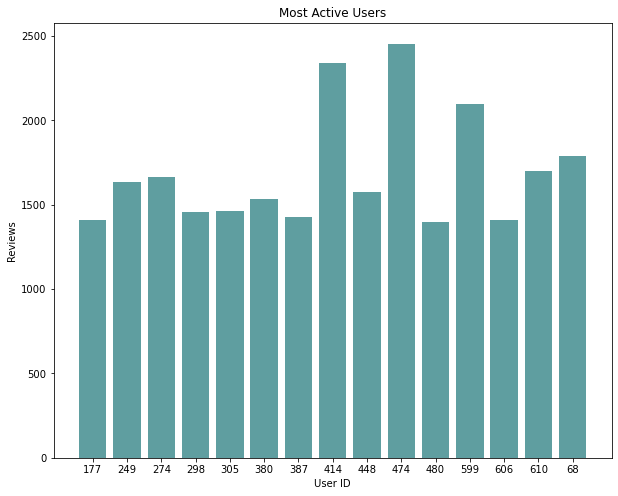

In [88]:
#making user_id a string for graphing
top_15_reviewers['user_id'] = top_15_reviewers['user_id'].astype(str)

#making sorted df for chart
top_15_sorted = top_15_reviewers.sort_values('review_count')

#making airbnb_rating a string

grouped = top_15_sorted.groupby("user_id")["review_count"].sum()

fig = plt.figure(figsize = (10, 8))

# create a bar plot
plt.bar(grouped.index, grouped.values, color="#5F9EA0")

# set the x-axis label
plt.xlabel("User ID")

# set the y-axis label
plt.ylabel("Reviews")

#adding title
plt.title("Most Active Users")

# show the plot
plt.show()

In [89]:
#making dataframe of rating counts to compare distribution of ratings
top_ratings = pd.DataFrame(movie_df["rating"].value_counts(ascending=False).head(15))
top_ratings = top_ratings.reset_index()
top_ratings = top_ratings.rename(columns={"rating":"rating_count"})
top_ratings = top_ratings.rename(columns={"index":"rating"})

#making user_id a string for plotting
top_ratings['rating'] = top_ratings['rating'].astype(str)

In [90]:
top_ratings

,rating,rating_count
0,4.0,64781
1,5.0,63845
2,4.5,31502
3,3.0,28550
4,3.5,22895
5,2.0,7955
6,2.5,6488
7,1.0,3721
8,0.5,1908
9,1.5,1568


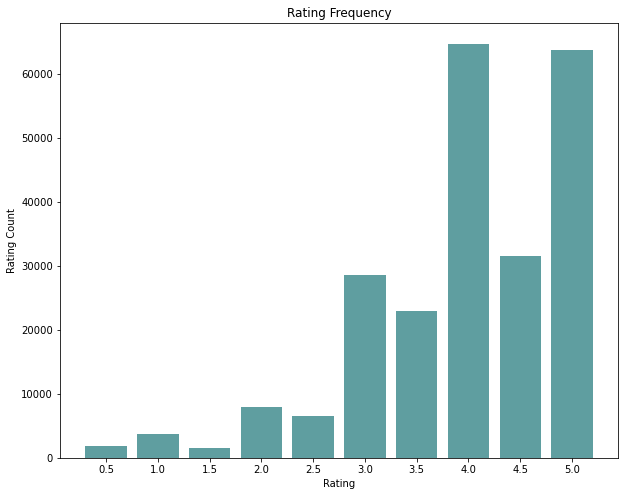

In [91]:
#making bar graph of rating frequency
grouped = top_ratings.groupby("rating")["rating_count"].sum()

fig = plt.figure(figsize = (10, 8))

# create a bar plot
plt.bar(grouped.index, grouped.values, color="#5F9EA0")

# set the x-axis label
plt.xlabel("Rating")

# set the y-axis label
plt.ylabel("Rating Count")

#adding title
plt.title("Rating Frequency")

# show the plot
plt.show()

In [92]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_15_sorted, x="user_id", y="review_count")
fig.update_layout(title_text='Most Active Users', title_x=0.5,
                  xaxis_title="User Id", yaxis_title="Review Count")
fig.update_traces(marker_color = "#5F9EA0")
fig.show()

In [93]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_ratings, x="rating", y="rating_count")
fig.update_layout(title_text='Rating Frequency', title_x=0.5,
                  xaxis_title="Rating", yaxis_title="Rating Count")
fig.update_traces(marker_color = "#5F9EA0")
fig.show()

# Model Preparation

With our dataset, we will need to perform user based collaborative filtering.

### One Hot Encoding

In [ ]:
#subpipe_numeric = Pipeline(steps=[('ss', StandardScaler())])
#subpipe_categorical = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown= 'ignore'))])
#CT = ColumnTransformer(transformers=[('subpipe_numeric', subpipe_numeric, scale),
#                                         ('subpipe_categorical', subpipe_categorical, cat)],
#                           remainder='passthrough')

additional resources
- https://www.analyticsvidhya.com/blog/2020/08/recommendation-system-k-nearest-neighbors/
- https://www.kaggle.com/code/ecemboluk/recommendation-system-with-cf-using-knn
- https://towardsdatascience.com/recommender-systems-and-hyper-parameter-tuning-25567b10e298

In [39]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 285760
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  233213 non-null  int64  
 1   item_id  233213 non-null  int64  
 2   rating   233213 non-null  float64
 3   genre_1  233213 non-null  object 
 4   genre_2  233213 non-null  object 
 5   genre_3  233213 non-null  object 
 6   genre_4  233213 non-null  object 
 7   genre_5  233213 non-null  object 
 8   year     233213 non-null  object 
 9   title    233213 non-null  object 
 10  tmdbId   233213 non-null  float64
 11  tag      233213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 23.1+ MB


#### Documentation for surprise
- https://surprise.readthedocs.io/en/stable/dataset.html

In [48]:
#dropping columns that aren't needed for Surprise (since )
surprise_df = movie_df.drop(columns=["title", "genre_1", "genre_2", "genre_3", "genre_4",
                                    "genre_5", "tmdbId", "tag", "year"])

In [49]:
surprise_df

,user_id,item_id,rating
0,1,1,4.0
1,1,1,4.0
2,1,1,4.0
3,1,3,4.0
4,1,3,4.0
...,...,...,...
285756,610,168252,5.0
285757,610,168252,5.0
285758,610,168252,5.0
285759,610,168252,5.0


In [50]:
from surprise import Reader, Dataset

reader = Reader()

data = Dataset.load_from_df(surprise_df, reader)

In [51]:
dataset = data.build_full_trainset()

print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  1554


In [52]:
#test grid search
params = {'n_factors': [200, 300],
          'reg_all': [.01, 0.02]}

g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1, cv=5, refit=True)

g_s_svd.fit(data)

In [ ]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

https://towardsdatascience.com/recommender-systems-and-hyper-parameter-tuning-25567b10e298